In [3]:
pip install yfinance


  Obtaining dependency information for yfinance from https://files.pythonhosted.org/packages/1b/0f/77716aa9dd84bb1aa5e93c87122af1de89697b6231f6d01d58d4e7c03c14/yfinance-0.2.36-py2.py3-none-any.whl.metadata
     ---------------------------------------- 0.0/314.6 kB ? eta -:--:--
     ------- ------------------------------- 61.4/314.6 kB 1.1 MB/s eta 0:00:01
     -------------------------------------- 314.6/314.6 kB 3.9 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
     ---------------------------------------- 0.0/2.9 MB ? eta -:--:--
     ----- ---------------------------------- 0.4/2.9 MB 9.1 MB/s eta 0:00:01
     ------------------ --------------------- 1.4/2.9 MB 10.9 MB/s eta 0:00:01
   

In [1]:
import yfinance as yf
import pandas as pd
import os

In [2]:
if os.path.exists("sp500.csv"):
    sp500 = pd.read_csv("sp500.csv", index_col=0)
else:
    sp500 = yf.Ticker("^GSPC")
    sp500 = sp500.history(period="max")
    sp500.to_csv("sp500.csv")

In [3]:
sp500.index = pd.to_datetime(sp500.index)

In [4]:
sp500

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,0.0,0.0
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,0.0,0.0
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,0.0,0.0
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
...,...,...,...,...,...,...,...
2024-01-17 00:00:00-05:00,4739.129883,4744.229980,4714.819824,4739.209961,3928600000,0.0,0.0
2024-01-18 00:00:00-05:00,4760.100098,4785.790039,4740.569824,4780.939941,4019000000,0.0,0.0
2024-01-19 00:00:00-05:00,4796.279785,4842.069824,4785.870117,4839.810059,4287200000,0.0,0.0


<Axes: xlabel='Date'>

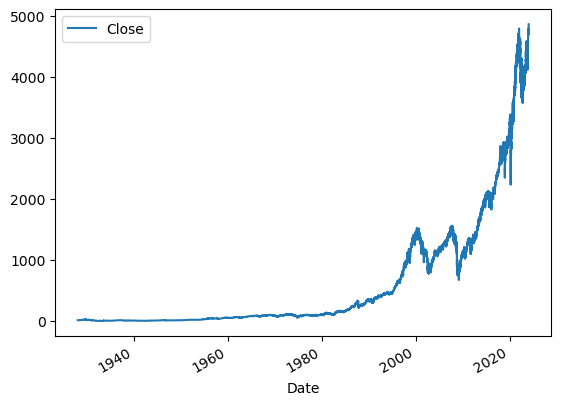

In [5]:
sp500.plot.line(y="Close", use_index=True)

In [6]:
del sp500["Dividends"]
del sp500["Stock Splits"]

In [ ]:
sp500 = sp500.loc["1990-01-01 00:00:00-05:00":].copy()

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

train = sp500.iloc[:-100]
test = sp500.iloc[-100:]

predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

In [29]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

0.5192307692307693

<Axes: xlabel='Date'>

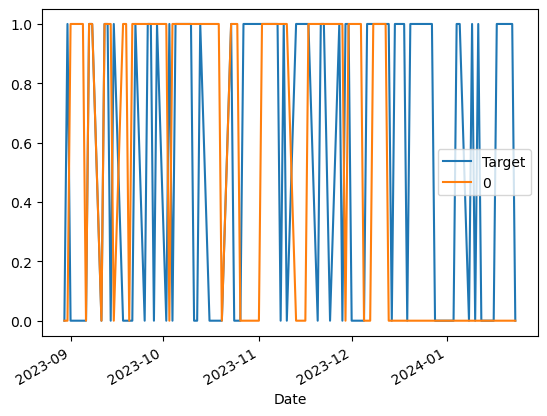

In [30]:
combined = pd.concat([test["Target"], preds], axis=1)
combined.plot()

In [31]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [32]:
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

In [33]:
predictions = backtest(sp500, model, predictors)

In [34]:
predictions["Predictions"].value_counts()

Predictions
0    12191
1     9439
Name: count, dtype: int64

In [35]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5171098633329801

In [36]:
predictions["Target"].value_counts() / predictions.shape[0]

Target
1    0.526214
0    0.473786
Name: count, dtype: float64

In [37]:
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = sp500.rolling(horizon).mean()
    
    ratio_column = f"Close_Ratio_{horizon}"
    sp500[ratio_column] = sp500["Close"] / rolling_averages["Close"]
    
    trend_column = f"Trend_{horizon}"
    sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"]
    
    new_predictors+= [ratio_column, trend_column]

In [38]:
sp500 = sp500.dropna(subset=sp500.columns[sp500.columns != "Tomorrow"])

In [40]:
sp500

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,
1931-12-29 00:00:00-05:00,7.960000,7.960000,7.960000,7.960000,0,8.100000,1,1.012723,1.0,0.996994,3.0,0.821282,24.0,0.582074,105.0,0.394305,521.0
1931-12-30 00:00:00-05:00,8.100000,8.100000,8.100000,8.100000,0,8.120000,1,1.008717,2.0,1.019381,3.0,0.837787,25.0,0.593657,105.0,0.401432,521.0
1931-12-31 00:00:00-05:00,8.120000,8.120000,8.120000,8.120000,0,7.560000,0,1.001233,2.0,1.017544,4.0,0.842149,25.0,0.596489,105.0,0.402615,522.0
1932-01-04 00:00:00-05:00,7.560000,7.560000,7.560000,7.560000,0,7.550000,0,0.964286,1.0,0.956962,3.0,0.785781,25.0,0.556754,104.0,0.375034,522.0
1932-01-05 00:00:00-05:00,7.550000,7.550000,7.550000,7.550000,0,8.080000,1,0.999338,0.0,0.960804,3.0,0.787963,24.0,0.557255,104.0,0.374726,521.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-17 00:00:00-05:00,4739.129883,4744.229980,4714.819824,4739.209961,3928600000,4780.939941,1,0.997184,0.0,0.993432,2.0,1.041357,37.0,1.096963,135.0,1.188638,527.0
2024-01-18 00:00:00-05:00,4760.100098,4785.790039,4740.569824,4780.939941,4019000000,4839.810059,1,1.004383,1.0,1.002285,2.0,1.048389,38.0,1.105719,136.0,1.198652,527.0
2024-01-19 00:00:00-05:00,4796.279785,4842.069824,4785.870117,4839.810059,4287200000,4850.430176,1,1.006119,2.0,1.012099,3.0,1.058888,39.0,1.118437,136.0,1.212935,528.0


In [ ]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [ ]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >=.6] = 1
    preds[preds <.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [43]:
predictions = backtest(sp500, model, new_predictors)

In [44]:
predictions["Predictions"].value_counts()

Predictions
0.0    17487
1.0     3143
Name: count, dtype: int64

In [45]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5962456251988546

In [46]:
predictions["Target"].value_counts() / predictions.shape[0]

Target
1    0.52889
0    0.47111
Name: count, dtype: float64

In [47]:
predictions

,Target,Predictions
Date,,
1942-01-07 00:00:00-05:00,0,0.0
1942-01-08 00:00:00-05:00,0,0.0
1942-01-09 00:00:00-05:00,0,0.0
1942-01-12 00:00:00-05:00,1,0.0
1942-01-13 00:00:00-05:00,0,0.0
...,...,...
2024-01-17 00:00:00-05:00,1,0.0
2024-01-18 00:00:00-05:00,1,0.0
2024-01-19 00:00:00-05:00,1,0.0
